# Analyzing Citi Bike Data with Python and Pandas

In [81]:
data1 = pd.read_csv('BikeStationBuffer')
data1.head()

,StationID,OBJECTID,tripduration,latitude,longitude
0,79,1,849.057723,40.719116,-74.006667
1,83,2,870.590206,40.683826,-73.976323
2,116,3,691.854660,40.741776,-74.001497
3,120,4,1036.931034,40.686768,-73.959282
4,128,5,821.978861,40.727103,-74.002971


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()

And now we load the trip data with Pandas:

In [2]:
trips = pd.read_csv('201609-citibike-tripdata.csv',
                    parse_dates=['starttime', 'stoptime'],
                    infer_datetime_format=True)
trips.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,975,2016-09-01 00:00:02,2016-09-01 00:16:18,312,Allen St & Stanton St,40.722055,-73.989111,313,Washington Ave & Park Ave,40.696102,-73.967510,22609,Subscriber,1985.0,1
1,1220,2016-09-01 00:00:04,2016-09-01 00:20:25,316,Fulton St & William St,40.709560,-74.006536,239,Willoughby St & Fleet St,40.691966,-73.981302,16966,Subscriber,1977.0,2
2,308,2016-09-01 00:00:19,2016-09-01 00:05:27,479,9 Ave & W 45 St,40.760193,-73.991255,448,W 37 St & 10 Ave,40.756604,-73.997901,25601,Subscriber,1983.0,1
3,250,2016-09-01 00:00:25,2016-09-01 00:04:35,297,E 15 St & 3 Ave,40.734232,-73.986923,487,E 20 St & FDR Drive,40.733143,-73.975739,22094,Subscriber,1953.0,1
4,439,2016-09-01 00:00:25,2016-09-01 00:07:45,494,W 26 St & 8 Ave,40.747348,-73.997236,533,Broadway & W 39 St,40.752996,-73.987216,16319,Subscriber,1985.0,1


## Exploring Trips over Time

Let's start by looking at the trend in number of daily trips over the course of the year

In [107]:
# Find the start date
ind = pd.DatetimeIndex(trips.starttime)
trips['date'] = ind.date.astype('datetime64')
trips['hour'] = ind.hour

In [108]:
# Count trips by date
by_date = trips.pivot_table('tripduration', aggfunc='count',
                            index='date',
                            columns='start station id', )

In [136]:
by_date_buffer = by_date[by_date.columns[by_date.columns.isin(data1.StationID)]].mean(axis=1)
by_date_buffer.head()

date
2016-09-01     75.126761
2016-09-02    101.332394
2016-09-03     76.272727
2016-09-04     83.036827
2016-09-05     84.498584
dtype: float64

In [137]:
by_date_nbuffer = by_date[by_date.columns[-by_date.columns.isin(data1.StationID)]].mean(axis=1)
by_date_nbuffer.head()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: numpy boolean negative, the `-` operator, is deprecated, use the `~` operator or the logical_not function instead.
  if __name__ == '__main__':


date
2016-09-01    53.567442
2016-09-02    78.861111
2016-09-03    68.758140
2016-09-04    77.730233
2016-09-05    72.595349
dtype: float64

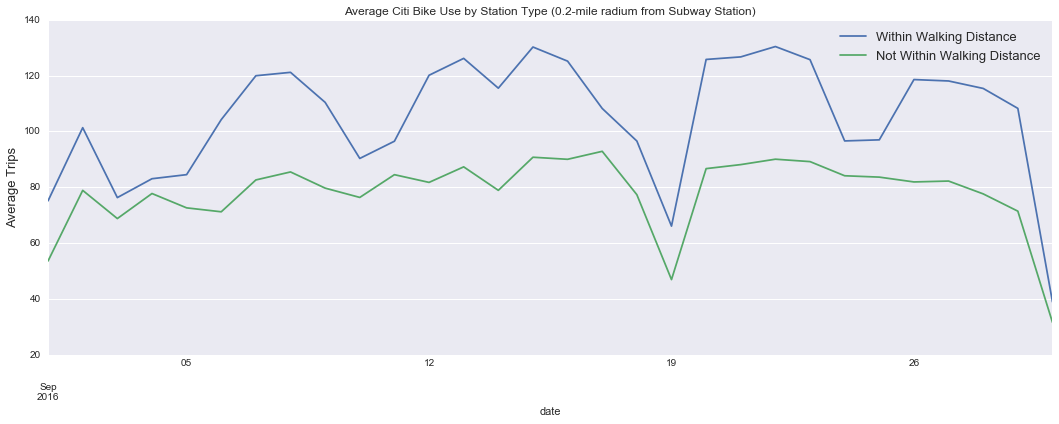

In [393]:
fig, ax = plt.subplots(1, figsize=(18, 6),sharey=True)
by_date_buffer.plot(title='Average Citi Bike Use by Station Type (0.2-mile radium from Subway Station)')
by_date_nbuffer.plot()
plt.legend(['Within Walking Distance', 'Not Within Walking Distance'],fontsize=13)
ax.set_ylabel('Average Trips',fontsize=13);
plt.savefig('buffer_month.png')

In [ ]:
by_weekday = by_date.groupby([by_date.index.dayofweek]).mean()

In [168]:
by_weekday_buffer = by_weekday[by_weekday.columns[by_weekday.columns.isin(data1.StationID)]].mean(axis=1)

In [169]:
by_weekday_nbuffer = by_weekday[by_weekday.columns[-by_weekday.columns.isin(data1.StationID)]].mean(axis=1)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: numpy boolean negative, the `-` operator, is deprecated, use the `~` operator or the logical_not function instead.
  if __name__ == '__main__':


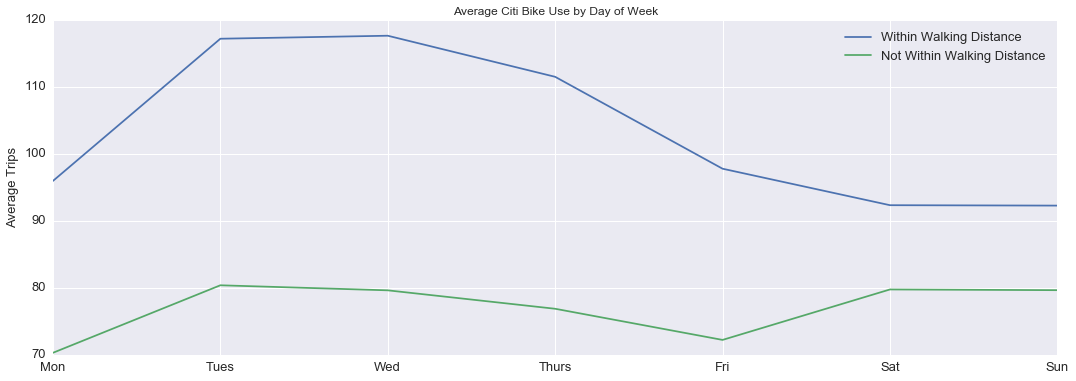

In [386]:
fig, ax = plt.subplots(1, figsize=(18, 6), sharey=True)
by_weekday_buffer.plot(title='Average Citi Bike Use by Day of Week',fontsize=13);
by_weekday_nbuffer.plot();
ax.set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'],fontsize=13)
plt.legend(['Within Walking Distance', 'Not Within Walking Distance'],fontsize=13)
ax.set_ylabel('Average Trips',fontsize=13);
plt.savefig('buffer_week.png')


It's also quite interesting to view the average hourly trips by weekday and weekend.
This takes a bit of manipulation:

In [179]:
# count trips by date and by hour
by_hour = trips.pivot_table('bikeid', aggfunc='count',
                            index=['date', 'hour'],
                            columns='start station id').fillna(0).reset_index('hour')

# average these counts by weekend
by_hour['weekend'] = (by_hour.index.dayofweek >= 5)
by_hour = by_hour.groupby(['weekend', 'hour']).mean()
by_hour.index.set_levels([['weekday', 'weekend'],
                          ["{0}:00".format(i) for i in range(24)]],
                         inplace=True);
by_hour.columns.name = None

In [181]:
by_hour_buffer = by_hour[by_hour.columns[by_hour.columns.isin(data1.StationID)]].mean(axis=1)

In [182]:
by_hour_nbuffer = by_hour[by_hour.columns[-by_hour.columns.isin(data1.StationID)]].mean(axis=1)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: numpy boolean negative, the `-` operator, is deprecated, use the `~` operator or the logical_not function instead.
  if __name__ == '__main__':


Now we can plot the results to see the hourly trends:

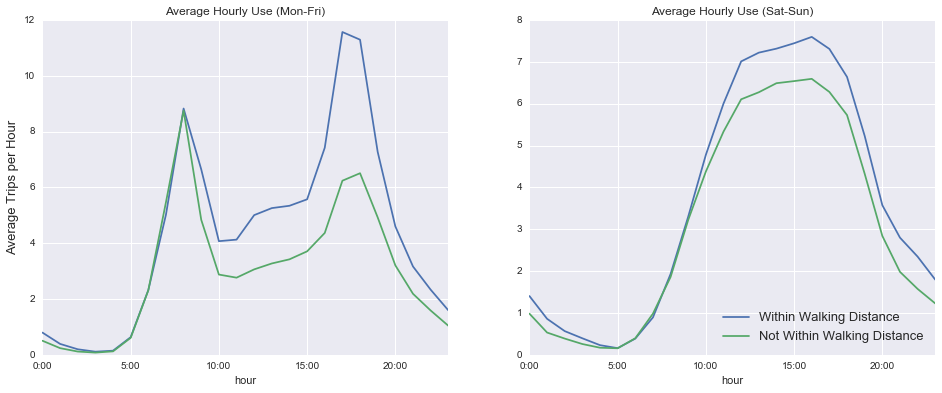

In [387]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=False)
by_hour_buffer.loc['weekday'].plot(title='Average Hourly Use (Mon-Fri)', ax=ax[0])
by_hour_nbuffer.loc['weekday'].plot(title='Average Hourly Use (Mon-Fri)', ax=ax[0])
by_hour_buffer['weekend'].plot(title='Average Hourly Use (Sat-Sun)', ax=ax[1])
by_hour_nbuffer['weekend'].plot(title='Average Hourly Use (Sat-Sun)', ax=ax[1])
plt.legend(['Within Walking Distance', 'Not Within Walking Distance'],fontsize=13,loc=4)
ax[0].set_ylabel('Average Trips per Hour', fontsize=13);
plt.savefig('buffer_hour.png')

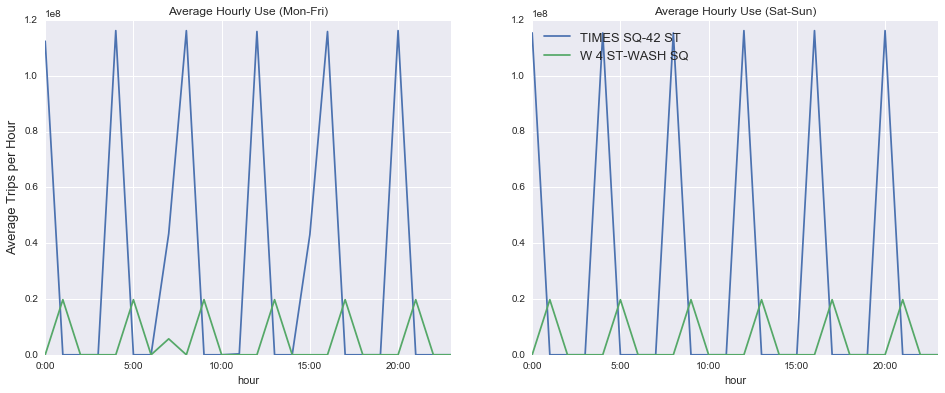

In [394]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=False)
by_hour_m.loc['weekday']['TIMES SQ-42 ST'].plot(title='Average Hourly Use (Mon-Fri)', ax=ax[0])
by_hour_m.loc['weekday']['W 4 ST-WASH SQ'].plot(title='Average Hourly Use (Mon-Fri)', ax=ax[0])
by_hour_m.loc['weekend']['TIMES SQ-42 ST'].plot(title='Average Hourly Use (Sat-Sun)', ax=ax[1])
by_hour_m.loc['weekend']['W 4 ST-WASH SQ'].plot(title='Average Hourly Use (Sat-Sun)', ax=ax[1])
plt.legend(['TIMES SQ-42 ST', 'W 4 ST-WASH SQ'],fontsize=13,loc=2)
ax[0].set_ylabel('Average Trips per Hour', fontsize=13);
plt.savefig('metro_hour.png')

In [312]:
mta = pd.read_csv('turnstile_160903.txt', index_col='DATE', parse_dates=True)
mta.columns

//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index([u'C/A', u'UNIT', u'SCP', u'STATION', u'LINENAME', u'DIVISION', u'TIME',
       u'DESC', u'ENTRIES',
       u'EXITS                                                               '],
      dtype='object')

In [335]:
mta2 = mta.groupby(mta.index).count()

Now we can take a look at how the number of rides scales with both Temperature and Precipitation, splitting the data by weekday and weekend:

In [ ]:
!curl -O http://web.mta.info/developers/data/nyct/turnstile/turnstile_160903.txt
!curl -O http://web.mta.info/developers/data/nyct/turnstile/turnstile_160910.txt
!curl -O http://web.mta.info/developers/data/nyct/turnstile/turnstile_160917.txt
!curl -O http://web.mta.info/developers/data/nyct/turnstile/turnstile_160924.txt
!curl -O http://web.mta.info/developers/data/nyct/turnstile/turnstile_161001.txt

For both temperature and precipitiation, we see trends in the direction we might expect (people ride more on warm, sunny days).
But there are some interesting details: *during the work week*, Annual and Short-term users are equally affected by the weather.
On the weekend, however, annual members appear **less** influenced by weather, while short-term users appear **more** influenced.
I don't have any good theories for why this would be the trend – please let me know if you have any ideas!

## Summary

There is a lot to glean from the above discussion, but I think there are several main takeaway points that we can learn from this look at the data:

- Annual Members and Day Pass users show markedly different behavior in aggregate: annual members seem to use Pronto mostly for commuting from point A to point B on Monday-Friday, while short-term users use Pronto primarily on weekends to explore particular areas of town.
- While annual members seem savvy to the pricing structure, **one out of four short-term-pass rides exceeds the half hour limit** and incurs an additional usage fee. For the sake of the customer, Pronto should probably make effort to better inform short-term users of this pricing structure.
- Elevation and weather affect use just as you would expect: there are 60% more downhill trips than uphill trips, and cold & rain significantly decrease the number of rides on a given day.

There is much more we could do with this data, and I'm hoping to dig more into it over the next couple weeks to seek some more detailed insights, but I think this is a good start!
If you're interested in entering the Pronto Data Challenge, feel free to use these scripts as a jumping-off point to answer your own questions about the data.

Thanks for reading!

<small>
This post was written entirely in the IPython notebook.  You can
[download](http://jakevdp.github.io/downloads/notebooks/ProntoData.ipynb)
this notebook, or see a static view
[here](http://nbviewer.ipython.org/url/jakevdp.github.io/downloads/notebooks/ProntoData.ipynb).
</small>

In [301]:
!curl -O http://web.mta.info/developers/data/nyct/turnstile/turnstile_160903.txt
!curl -O http://web.mta.info/developers/data/nyct/turnstile/turnstile_160910.txt
!curl -O http://web.mta.info/developers/data/nyct/turnstile/turnstile_160917.txt
!curl -O http://web.mta.info/developers/data/nyct/turnstile/turnstile_160924.txt
!curl -O http://web.mta.info/developers/data/nyct/turnstile/turnstile_161001.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24.1M    0 24.1M    0     0  10.6M      0 --:--:--  0:00:02 --:--:-- 10.8M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24.3M    0 24.3M    0     0  10.8M      0 --:--:--  0:00:02 --:--:-- 10.8M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24.0M    0 24.0M    0     0  1447k      0 --:--:--  0:00:17 --:--:-- 1486k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24.0M    0 24.0M    0     0  10.9M      0 --:--:--  0:00:02 --:--:-- 11.0M
  % Total    % Received % Xferd  Average Speed   Tim

In [210]:
mta = pd.read_csv('turnstile_160903.txt', parse_dates=['DATE'],
                    infer_datetime_format=True)
mta.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-08-27,00:00:00,REGULAR,5799442,1966041
1,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-08-27,04:00:00,REGULAR,5799463,1966044
2,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-08-27,08:00:00,REGULAR,5799492,1966079
3,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-08-27,12:00:00,REGULAR,5799610,1966155
4,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-08-27,16:00:00,REGULAR,5799833,1966214


In [ ]:
mta.set

In [237]:
ind = pd.DatetimeIndex(mta.DATE)
indd = pd.DatetimeIndex(mta.TIME)
mta['date'] = ind.date.astype('datetime64')
mta['hour'] = indd.hour

In [241]:
mta.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,date,hour
0,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-08-27,00:00:00,REGULAR,5799442,1966041,2016-08-27,0
1,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-08-27,04:00:00,REGULAR,5799463,1966044,2016-08-27,4
2,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-08-27,08:00:00,REGULAR,5799492,1966079,2016-08-27,8
3,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-08-27,12:00:00,REGULAR,5799610,1966155,2016-08-27,12
4,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-08-27,16:00:00,REGULAR,5799833,1966214,2016-08-27,16


In [242]:
# count trips by date and by hour
by_hour_m = mta.pivot_table('ENTRIES', aggfunc='mean',
                            index=['date', 'hour'],
                            columns='STATION').fillna(0).reset_index('hour')

# average these counts by weekend
by_hour_m['weekend'] = (by_hour_m.index.dayofweek >= 5)
by_hour_m = by_hour_m.groupby(['weekend', 'hour']).mean()
by_hour_m.index.set_levels([['weekday', 'weekend'],
                          ["{0}:00".format(i) for i in range(24)]],
                         inplace=True);
by_hour_m.columns.name = None

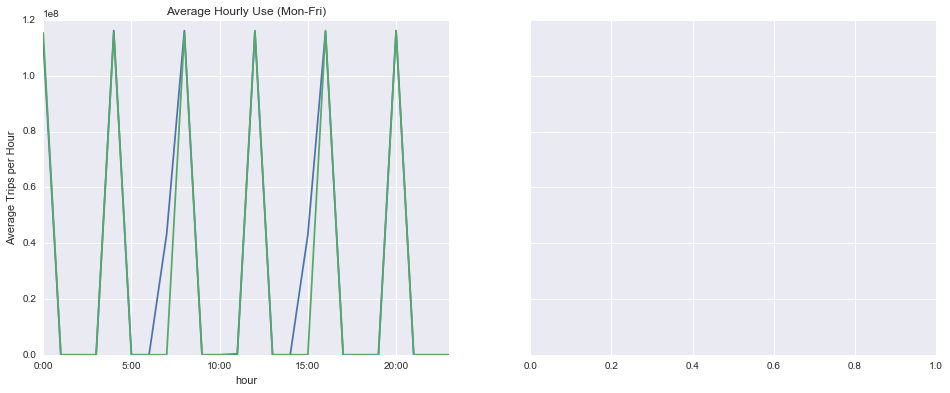

In [347]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
by_hour_m.loc['weekday']['TIMES SQ-42 ST'].plot(title='Average Hourly Use (Mon-Fri)', ax=ax[0])
by_hour_m.loc['weekend']['TIMES SQ-42 ST'].plot(title='Average Hourly Use (Mon-Fri)', ax=ax[0])
#by_hour_m.loc['weekend'].mean(axis=1).plot(title='Average Hourly Use (Sat-Sun)', ax=ax[1])
ax[0].set_ylabel('Average Trips per Hour');

In [249]:
by_hour_m.loc['weekday']['1 AV']

hour
0:00     1.412321e+08
1:00     0.000000e+00
2:00     0.000000e+00
3:00     0.000000e+00
4:00     1.412321e+08
5:00     0.000000e+00
6:00     0.000000e+00
7:00     0.000000e+00
8:00     1.412323e+08
9:00     0.000000e+00
10:00    0.000000e+00
11:00    0.000000e+00
12:00    1.412327e+08
13:00    0.000000e+00
14:00    0.000000e+00
15:00    0.000000e+00
16:00    1.412331e+08
17:00    0.000000e+00
18:00    0.000000e+00
19:00    0.000000e+00
20:00    1.412337e+08
21:00    0.000000e+00
22:00    0.000000e+00
23:00    0.000000e+00
Name: 1 AV, dtype: float64

In [346]:
for i in by_date_mta.columns:
    print i

1 AV
103 ST
103 ST-CORONA
104 ST
110 ST
111 ST
116 ST
116 ST-COLUMBIA
121 ST
125 ST
135 ST
137 ST CITY COL
138/GRAND CONC
14 ST
14 ST-UNION SQ
145 ST
149/GRAND CONC
14TH STREET
15 ST-PROSPECT
155 ST
157 ST
161/YANKEE STAD
163 ST-AMSTERDM
167 ST
168 ST
169 ST
170 ST
174 ST
174-175 STS
175 ST
176 ST
18 AV
18 ST
181 ST
182-183 STS
183 ST
190 ST
191 ST
2 AV
20 AV
207 ST
21 ST
21 ST-QNSBRIDGE
215 ST
219 ST
225 ST
23 ST
231 ST
233 ST
238 ST
25 AV
25 ST
28 ST
3 AV
3 AV 138 ST
3 AV-149 ST
30 AV
33 ST
33 ST-RAWSON ST
34 ST-HERALD SQ
34 ST-HUDSON YD
34 ST-PENN STA
36 AV
36 ST
39 AV
4 AV-9 ST
40 ST LOWERY ST
42 ST-BRYANT PK
42 ST-PORT AUTH
45 ST
46 ST
46 ST BLISS ST
47-50 STS ROCK
49 ST
4AV-9 ST
5 AV/53 ST
5 AV/59 ST
5 AVE
50 ST
51 ST
52 ST
53 ST
55 ST
57 ST
57 ST-7 AV
59 ST
59 ST COLUMBUS
6 AV
61 ST WOODSIDE
63 DR-REGO PARK
65 ST
66 ST-LINCOLN
67 AV
68ST-HUNTER CO
69 ST
7 AV
71 ST
72 ST
74 ST-BROADWAY
75 AV
75 ST-ELDERTS
77 ST
79 ST
8 AV
8 ST-NYU
80 ST
81 ST-MUSEUM
82 ST-JACKSON H
85 ST-FOREST P

In [281]:
station_population = pd.read_csv('Station_Population.txt')
station_population.head()

,FID,OBJECTID,StationID,tripdurati,latitude,longitude,FID_1,BoroCode,BoroName,CountyFIPS,NTACode,NTAName,Shape_Leng,Shape_Area,all_househ,child_per_,Borough_Co,Total_Popu
0,0,139,447,913.936277,40.763707,-73.985162,13,1,Manhattan,61,MN15,Clinton,35037.171581,1.838138e+07,2545.0,424.166667,61,45884.0
1,1,140,449,843.960385,40.764618,-73.987895,13,1,Manhattan,61,MN15,Clinton,35037.171581,1.838138e+07,2545.0,424.166667,61,45884.0
2,2,141,450,791.922473,40.762272,-73.987882,13,1,Manhattan,61,MN15,Clinton,35037.171581,1.838138e+07,2545.0,424.166667,61,45884.0
3,3,157,479,837.528228,40.760193,-73.991255,13,1,Manhattan,61,MN15,Clinton,35037.171581,1.838138e+07,2545.0,424.166667,61,45884.0
4,4,163,488,840.844720,40.756458,-73.993722,13,1,Manhattan,61,MN15,Clinton,35037.171581,1.838138e+07,2545.0,424.166667,61,45884.0
